## 2021321148 INSIK CHO   Assignment 8

In [ ]:
# I installed needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from itertools import combinations, permutations
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings(action='ignore')

##  data loading



In [226]:
# adjacency matrix 데이터를 삽입할 dataframe을 정의합니다. 
df = np.zeros((34,34))

# 본래 list로 작성된 adjacency data를 행려롤 전환
with open("karate_club.adjlist") as file:
    for _ in range(3):
        next(file)
        
# 파일의 줄마다 pair를 찾고 있을 시 1을 부여
    for line in file:
        node = list(map(int, line.split()))
        i = node[0]
        for j in node[1:]:
            df[i][j] = 1
            df[j][i] = 1
    file.close()
    
label = np.loadtxt("karate_label.txt")

## LINE Class

In [227]:
class LINE():
    
    def __init__(self,random_state = 42, epochs = 500):
        self.random_state = random_state
        self.epochs = epochs 
        
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
        
        
    def first_prox(self,df,hidden_size=2,lr = 0.02):
        input_size = df.shape[0]

        # 초기값 설정. 그냥 normal에서 랜덤추출.
        np.random.seed(self.random_state)
        self.embedding_matrix_first = np.random.normal(0,0.05,[input_size,hidden_size])

        # ij pair index. first order에서
        # edge마다 연결해야 하므로, 랜덤으로 추출할 수 있는 matrix 형성
        index = np.arange(0,input_size)
        # 2개씩 랜덤으로 뽑아내는 방식으로 combination 함수 사용.
        edge = list(combinations(index,2))
        np.random.shuffle(edge)

        # 해당 함수를 통해 도출되는 값은 embedding matrix와
        # 해당 훈련과정에서 발생하는 cost. cost는 해당 함수의 결과로 반환하도록 설정.
        cost = []
        for epoch in range(self.epochs):
            # edge마다 u_i와 u_j의 로지스틱 함수(비용)을 극소화하기 위해 
            # 앞서 정한 모든 (i,j) edge에 대해 u_i와 u_j를 설정하고
            # 이를 각각 업데이트 합니다. 
            for k in range(len(edge)):
                i = edge[k][0]
                j = edge[k][1]
                ui = self.embedding_matrix_first[i]
                uj = self.embedding_matrix_first[j]
                #가중치가 없으므로, 연결이 되면 1, 아되면 0으로 w_ij 를 대입.
                wij = df[i,j]
                # 확률은 시그모이드 사용.
                p1 = self.sigmoid(ui @ uj)
                # gradient
                g_ui = -wij*(1-p1)*(uj)
                g_uj = -wij*(1-p1)*(ui)
                # update
                ui -= lr*g_ui
                uj -= lr*g_uj

            # 매 epoch 이후 cost를 계산해서 cost 함수에 추가합니다.
            error = 0
            for k in range(len(comb)):
                i = edge[k][0]
                j = edge[k][1]

                ui = self.embedding_matrix_first[i]
                uj = self.embedding_matrix_first[j]
                wij = df[i,j]

                p1 = self.sigmoid(ui @ uj)

                error -= wij*np.log(p1)    
            cost.append(error)
        return cost
    
    def second_prox(self, df,hidden_size=2,lr = 0.02):
        input_size = df.shape[0]

        # 초기값 설정
        # second approx에서는 context도 해야하므로 context도 초깃값 설정
        np.random.seed(self.random_state)
        self.embedding_matrix_second = np.random.normal(0,0.1,[input_size,hidden_size])
        self.context_matrix =  np.random.normal(0,0.1,[input_size,hidden_size])

        # combination 적용하여 pair list 생성
        # 1st와는 다르게 permutation을 적용했는데, 수식상 모든 embedding matrix와의
        # 식을 적어야 하기 때문.
        index = np.arange(0,input_size)
        edge = list(permutations(index,2))
        np.random.shuffle(edge)


        cost = []
        for epoch in range(self.epochs):
            # edge마다 u_i와 u_j의 로지스틱 함수(비용)을 극소화하기 위해 
            # 앞서 정한 모든 (i,j) edge에 대해 u_i와 u_j를 설정하고
            # 이를 각각 업데이트 합니다. 
            for k in range(len(edge)):
                i = edge[k][0]
                j = edge[k][1]
                # ij pair
                ui = self.embedding_matrix_second[i]
                uj = self.context_matrix[j]
                wij = df[i,j]
                # 가중치가 없으므로, 연결이 되면 1, 아되면 0으로 w_ij 를 대입.
                # 수식에서 공통적으로 나오는 부분은 numerator, denominator로 저장함.
                numerator = 0
                denominator = 0 

                for v in range(input_size):
                    uv = self.context_matrix[v]
                    numerator += uv * np.exp( uv @ ui )
                    denominator += np.exp(uv @ ui)

                grad_ui = wij*(-uj + numerator/denominaotr)

                # gradient of embedding vector, especially j
                grad_uj = wij*(-ui + ui*np.exp(uj @ ui)/denominator)
                
                # grad_uj를 제외한 다른 grad들은 다른 식을 사용하므로, 구분함.
                index_without_j = np.arange(34).tolist()
                index_without_j.pop(j)

                for l in index_without_j:
                    ul = self.context_matrix[l]
                    grad_ul = wij*(ui*np.exp(ua @ ui)/denominator)
                    # update
                    ul -= lr*grad_ul


                # update
                ui -= lr*grad_ui
                uj -= lr*grad_uj


            # Error calculation
            error = 0
            for k in range(len(edge)):
                i = edge[k][0]
                j = edge[k][1]

                ui = self.embedding_matrix_second[i]
                uj = self.context_matrix[j]
                wij = df[i,j]

                p2 = np.exp(uj @ ui)/np.sum(np.exp(ui @ self.context_matrix.T))

                error -= wij*np.log(p2)
            cost.append(error)

        return cost
    
    # concatenation의 경우, 과제 요구사항에는 없지만 한번 해봤습니다.
    # 원 논문에 따르면 두 embedding vector를 concatenation하는 것만으로도
    # 충분한 성능이 나온다고 합니다. 
    def train(self, df,hidden_size=2,lr = 0.02):
        self.first_prox(df, hidden_size = hidden_size, lr = lr)
        self.second_prox(df, hidden_size = hidden_size, lr = lr)
        self.embedding_line =  np.concatenate((self.embedding_matrix_first,self.embedding_matrix_second),axis=1)
        return self.embedding_line
        

## Training

두 prox.에 대한 트레이닝입니다. 

Second proximation의 경우 아무래도 분모 파트에서 엄청난 계산이 들어가다보니, 소요시간이 깁니다. 

First prox.는 금방 수렴하지만, Second prox.는 수렴이 느린 것 같아 Learning_rate을 조금 올렸습니다.

(0.02 -> 0.04)



### First proximation

In [228]:
line = LINE()
start = time.time()
first_cost = line.first_prox(df, lr = 0.04)
print("소요시간_first: ", (time.time() - start))

소요시간_first:  3.8199303150177


### Second proximation

In [229]:
start = time.time()
second_cost = line.second_prox(df, lr = 0.04)
print("소요시간_second: ", (time.time() - start))

소요시간_second:  266.2664086818695


## Cost Graph

Cost로 미루어보아 충분히 수렴을 한다는 것을 알 수 있습니다.

Text(0, 0.5, 'Cost')

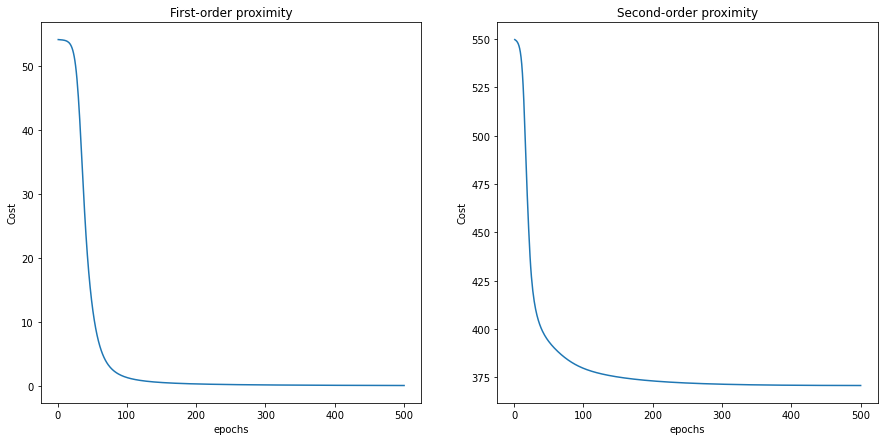

In [253]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
xlim = range(1,501)
plt.plot(xlim,first_cost)
plt.title("First-order proximity")
plt.xlabel("epochs")
plt.ylabel("Cost")

plt.subplot(1,2,2)
xlim = range(1,501)
plt.plot(xlim,second_cost)
plt.title("Second-order proximity")
plt.xlabel("epochs")
plt.ylabel("Cost")


## Comparison

설명에 필요한 Graph 정보를 보고자 networkx 패키지를 이용해 주어진 가라테 데이터를 시각화했습니다.

해당 패키지를 사용해도 괜찮을지는 잘 모르겠는데.. 결과에 영향을 주는 패키지는 아니라서 사용해도 

괜찮을 것이라 판단했습니다.

Text(0.5, 1.0, 'karate club network')

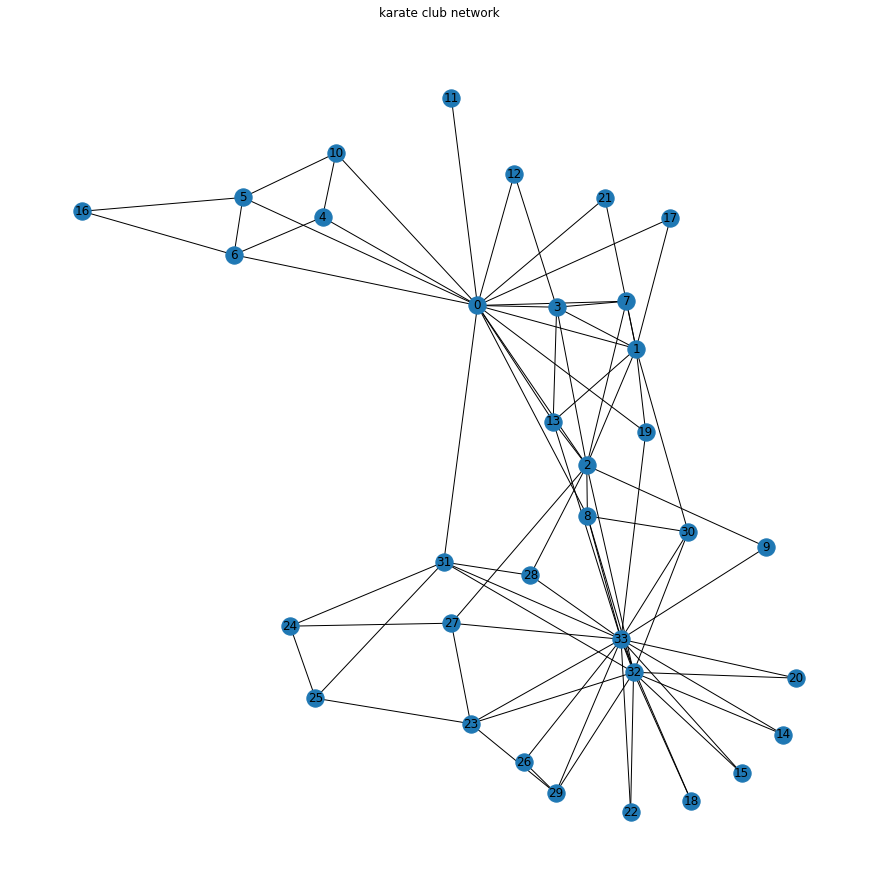

In [254]:
plt.figure(figsize = (12,12))
network = nx.read_adjlist('karate_club.adjlist')
nx.draw(network, with_labels=True) 
plt.title("karate club network")

위 그래프를 바탕으로 수업시간에 배운  first prox. 와 second prix. 의 차이를 보여줄만한 vertex가 무엇이 있을지 찾아봤습니다.

후보군은

1. [14,15,18,20,22]

2. [17,21]

3. [4,5,6,10] 

3가지입니다. 이 세 가지를 살펴보면 직접 연결은 안돼있지만, 간접적으로는 높은 연관도를 보입니다.

(4,5,6,10의 경우 연결이 되어있는 경우도 있고 안되어있는 경우도 있지만, 일단은 통째로 보고자 했습니다.)

LINE 알고리즘이 잘 적용됐다면 first에서는 떨어져있고, second에서는 붙어있을 것이라 가정했습니다. 

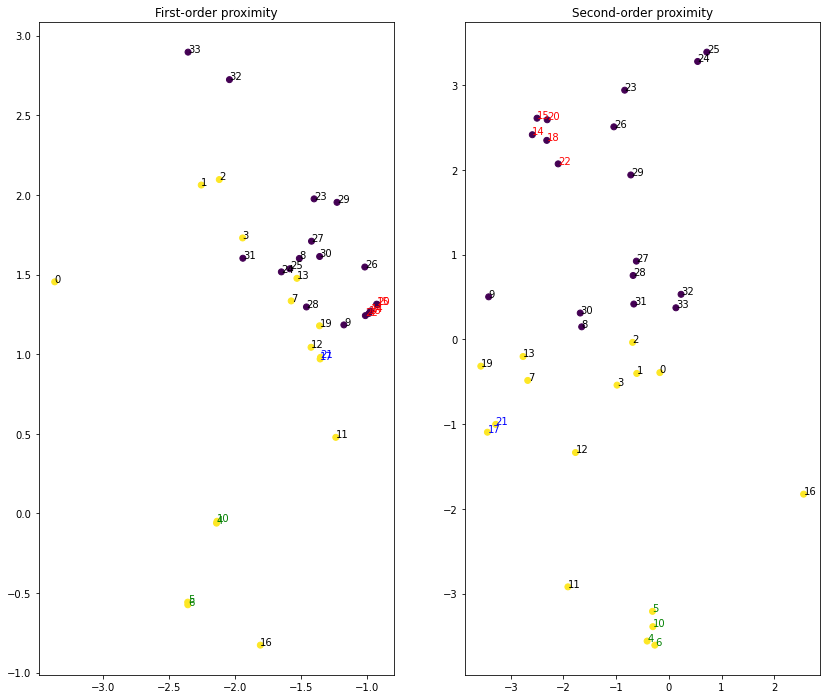

In [255]:
plt.figure(figsize=(14,12))

plt.subplot(1,2,1)
plt.scatter(line.embedding_matrix_first[:,0],line.embedding_matrix_first[:,1],c=label[:,1])
for i in range(df.shape[0]):
    if i in [14,15,18,20,22]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'r')
    elif i in [17,21]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'b')
    elif i in [4,5,6,10]:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i, c= 'g')
    else:
        plt.text(line.embedding_matrix_first[:,0][i], line.embedding_matrix_first[:,1][i],i)
plt.title("First-order proximity")

plt.subplot(1,2,2)
plt.scatter(line.embedding_matrix_second[:,0],line.embedding_matrix_second[:,1],c=label[:,1])
for i in range(df.shape[0]):
    if i in [14,15,18,20,22]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'r')
    elif i in [17,21]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'b')
    elif i in [4,5,6,10]:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i, c= 'g')
    else:
        plt.text(line.embedding_matrix_second[:,0][i], line.embedding_matrix_second[:,1][i],i)
plt.title("Second-order proximity")
plt.show()

위 그래프를 확인하면, [14,15,18,20,22]와 [17,21]은 first에서도, second에서도 매우 가깝게 붙어있는 것을 확인할 수 있습니다. 

이는 각각 빨간색, 파란색 숫자로 적힌 점을 확인하면 됩니다. 

데이터가 그리 크지 않다보니, LINE 알고리즘이 둘 다에서 매우 높은 적합도를 보여서 그런게 아닐까.. 생각했습니다.

하지만 마지막 후보인 [4,5,6,10]에서는 유의미한 결과를 볼 수 있습니다. 

Second prox.에서는 [4,5,6,10]이 모두 매우 가깝게 위치한 것을 알 수 있습니다.

그러나 first prox.에서는 이 중 w_ij = 1값을 가지는 4와 10, 5와 6이 붙어 있고 

4,10과  5,6은 멀지는 않지만 조금 떨어져 있는 것을 확인할 수 있습니다.

즉, 수업시간에 배운 LINE 알고리즘의 특징이 들어나는 것으로 보입니다. 


## concatenation

원 논문은 first prox.와 second prox. 를 concatenation 하는 것 만으로 충분하다고 언급했습니다.

In [233]:
line = LINE()
line.train(df)

array([[-3.36729244,  1.45428316, -0.170046  , -0.3923181 ],
       [-2.25808317,  2.06219609, -0.60880363, -0.4022016 ],
       [-2.12154231,  2.09672837, -0.68804742, -0.03532717],
       [-1.94514667,  1.73006489, -0.98295692, -0.54030311],
       [-2.14247478, -0.06092432, -0.41167677, -3.56139859],
       [-2.36051545, -0.55711984, -0.30977839, -3.21048695],
       [-2.35992825, -0.57375842, -0.2656073 , -3.60970174],
       [-1.57724446,  1.33458743, -2.67818964, -0.4847548 ],
       [-1.51555637,  1.60134778, -1.6539195 ,  0.1481865 ],
       [-1.17856481,  1.18384974, -3.41983804,  0.50234856],
       [-2.13878598, -0.04910868, -0.3033974 , -3.39152509],
       [-1.23976247,  0.47774458, -1.91568679, -2.92143175],
       [-1.42713917,  1.04336544, -1.77209335, -1.33568733],
       [-1.53395452,  1.47637215, -2.76694829, -0.20222775],
       [-0.97712471,  1.27130059, -2.59101631,  2.41589561],
       [-0.93061197,  1.31410532, -2.50194605,  2.61096576],
       [-1.81095834, -0.

concatenation 한 경우, 이차원평면에 나타낼 수 없어, t-sne 함수를 이용했습니다. 

이 경우 4,5,6,10도 뭉치는 모습을 확인할 수 있습니다. 

그렇지만 데이터가 워낙 fitting이 잘 돼서, 큰 차이를 보이는 것 같지는 않습니다.

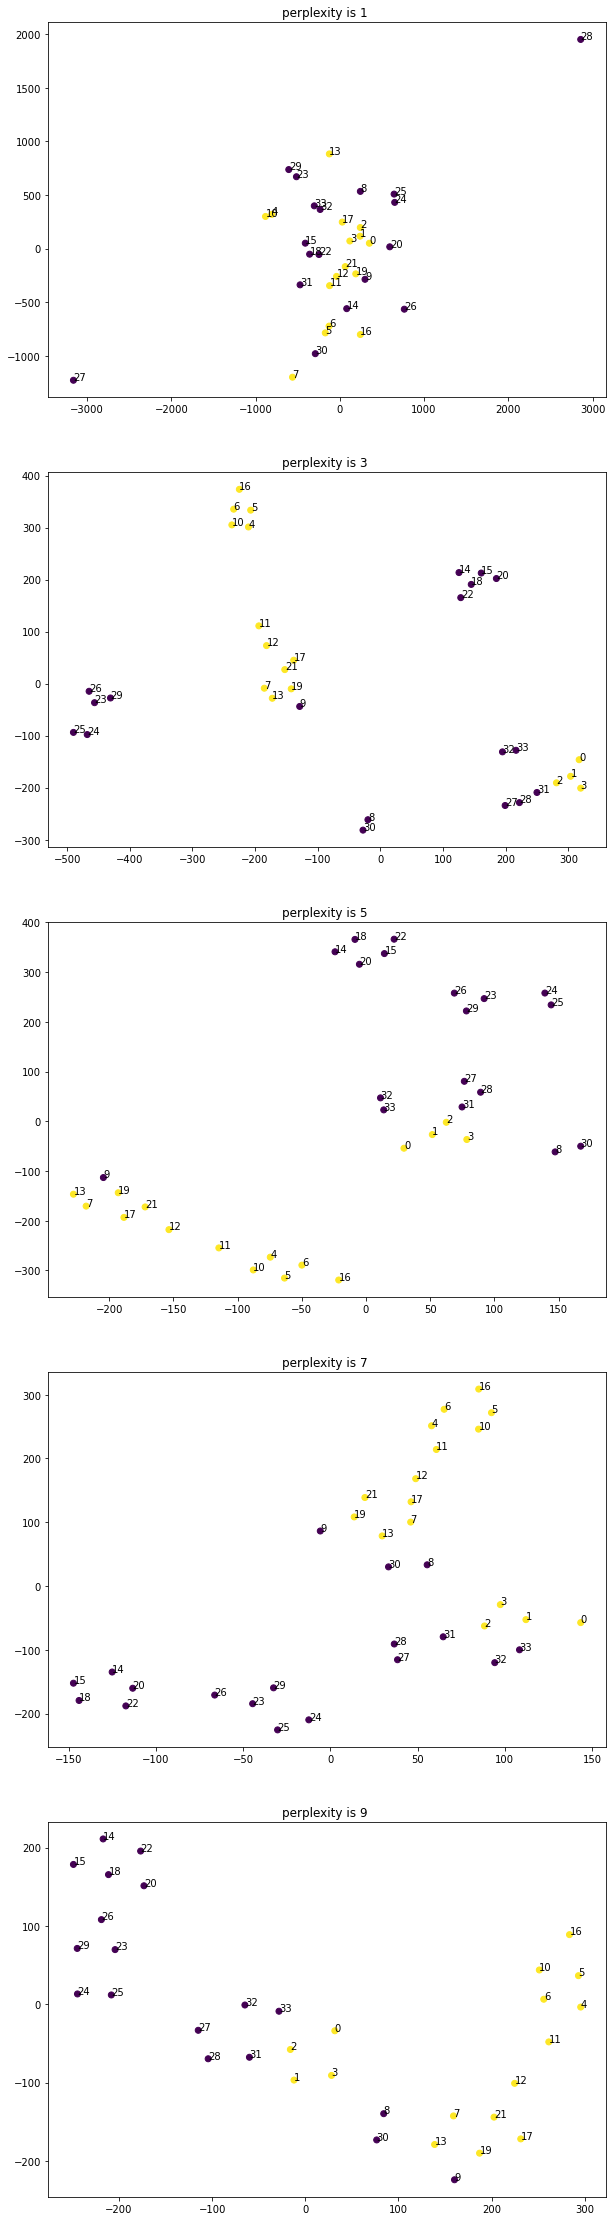

In [252]:
#1,3,5,7,9
perplexity = np.arange(1,10,2)
#The code to draw 5 graphs
fig, axes =plt.subplots(5, figsize=(10,40))
for i in range(5):
    tsne = TSNE(n_components = 2, perplexity = perplexity[i], metric = 'cosine')
    y = tsne.fit_transform(line.embedding_line)
    x = y[:,0]
    y = y[:,1]
    axes[i].scatter(x,y, c=label[:,1])
    for j in range(df.shape[0]):
        axes[i].text(x[j],y[j],j)
    axes[i].title.set_text('perplexity is {} '.format(perplexity[i]))
